# ST5225 Statistical Analysis of Networks — Hands-On Activities
# Week 2 — Basic Quantities and Properties of Networks 

### 1. Download the data

We first download the [European powergrid data](https://zenodo.org/records/47317). These files contain network models of the European and North-American high-voltage power grid, extracted by [GridKit](https://github.com/bdw/GridKit).  These extracts form a topological network with stations in one file (vertices.csv) and lines in another (links.csv). This network is intended for use in power system analysis. OpenStreetMap is the primary data source for these networks.



### 2. Load the data into Python

Read the CSV files into python using pandas.

In [1]:
import pandas as pd

# Load data from CSV files
vertices_df = pd.read_csv('gridkit_europe-highvoltage-vertices.csv')
links_df = pd.read_csv('gridkit_europe-highvoltage-links.csv')



### 3. Create a network


In [2]:
import networkx as nx

# Create a graph
G = nx.Graph()

# Add vertices (nodes) with attributes
for _, row in vertices_df.iterrows():
    G.add_node(row['v_id'], 
               lon=row['lon'], 
               lat=row['lat'], 
               typ=row['typ'], 
               voltage=row['voltage'], 
               frequency=row['frequency'], 
               name=row['name'], 
               operator=row['operator'], 
               ref=row['ref'], 
               wkt_srid_4326=row['wkt_srid_4326'])

# Add edges with attributes
for _, row in links_df.iterrows():
    G.add_edge(row['v_id_1'], row['v_id_2'], 
               voltage=row['voltage'], 
               cables=row['cables'], 
               wires=row['wires'], 
               frequency=row['frequency'], 
               name=row['name'], 
               operator=row['operator'], 
               ref=row['ref'], 
               length_m=row['length_m'], 
               r_ohmkm=row['r_ohmkm'], 
               x_ohmkm=row['x_ohmkm'], 
               c_nfkm=row['c_nfkm'], 
               i_th_max_a=row['i_th_max_a'], 
               from_relation=row['from_relation'], 
               wkt_srid_4326=row['wkt_srid_4326'])

# Display the graph info
print(G)


Graph with 13871 nodes and 17277 edges


### 4. Visualise the network

Use "geopandas" to visualise the network. Download the shapefile from [here](https://www.naturalearthdata.com/downloads/110m-cultural-vectors/), under "Admin 0 – Countries".

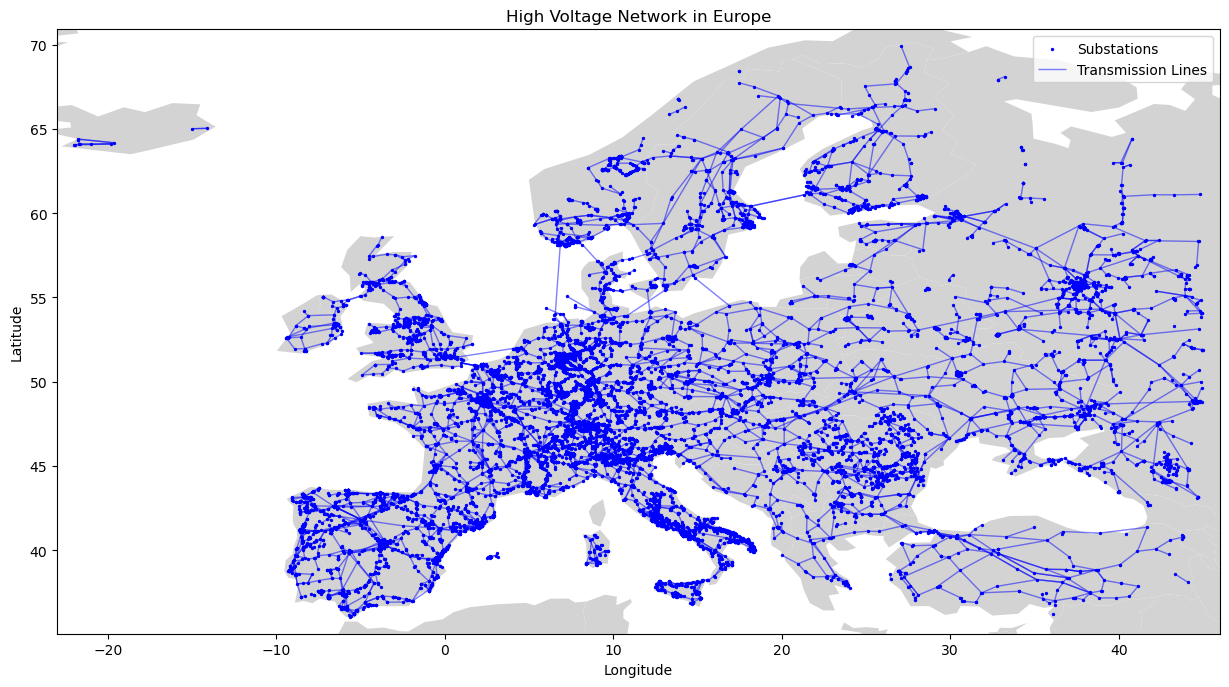

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString

# Create GeoDataFrame for vertices
geometry = [Point(xy) for xy in zip(vertices_df.lon, vertices_df.lat)]
gdf_vertices = gpd.GeoDataFrame(vertices_df, geometry=geometry)

# Create GeoDataFrame for edges
edge_lines = [LineString([Point(G.nodes[data['v_id_1']]['lon'], G.nodes[data['v_id_1']]['lat']),
                          Point(G.nodes[data['v_id_2']]['lon'], G.nodes[data['v_id_2']]['lat'])]) 
              for _, data in links_df.iterrows()]

gdf_edges = gpd.GeoDataFrame(links_df, geometry=edge_lines)

# Determine min and max of the vertex coordinates
min_lon = vertices_df['lon'].min()
max_lon = vertices_df['lon'].max()
min_lat = vertices_df['lat'].min()
max_lat = vertices_df['lat'].max()

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

# Load the world basemap from local directory
world = gpd.read_file('ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')  # Update this path

# Plot the basemap
world.plot(ax=ax, color='lightgrey')

# Plot vertices
gdf_vertices.plot(ax=ax, marker='o', color='blue', markersize=2, label='Substations')

# Plot edges
gdf_edges.plot(ax=ax, color='blue', linewidth=1, alpha=0.5, label='Transmission Lines')

# Set limits to zoom into the relevant part of Europe based on vertex coordinates
ax.set_xlim(min_lon - 1, max_lon + 1)  # Adding a small buffer for better visualization
ax.set_ylim(min_lat - 1, max_lat + 1)  # Adding a small buffer for better visualization

plt.legend()
plt.title('High Voltage Network in Europe')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


### 4. Extract degree distribution


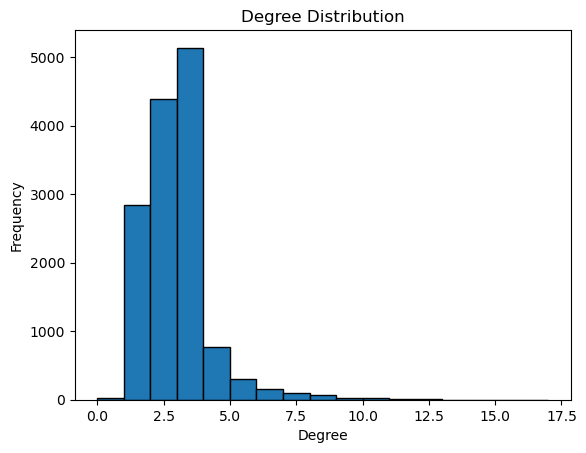

In [4]:
import matplotlib.pyplot as plt

# Extract the degree distribution
degree_distribution = [degree for _, degree in G.degree()]

# Plot the degree distribution
plt.hist(degree_distribution, bins=range(min(degree_distribution), max(degree_distribution) + 2, 1), edgecolor='black')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution')
plt.show()

### 5. Betweeness Centrality

Use Betweeness Centrality to find the critically important power stations in the power grid. Visualise.

In [5]:
import networkx as nx

# Calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G, k= 500)

# Sort the power stations by their betweenness centrality
sorted_power_stations = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)

# Print the top 10 power stations with highest betweenness centrality
print("Top 10 power stations with highest betweenness centrality:")
for station, centrality in sorted_power_stations[:10]:
  print(f"Power Station: {station}, Betweenness Centrality: {centrality}")



Top 10 power stations with highest betweenness centrality:
Power Station: 54736, Betweenness Centrality: 0.2695591716334277
Power Station: 5159, Betweenness Centrality: 0.26204311111999806
Power Station: 6465, Betweenness Centrality: 0.26010856816643274
Power Station: 20710, Betweenness Centrality: 0.2524277371770081
Power Station: 55425, Betweenness Centrality: 0.2502460702767068
Power Station: 22202, Betweenness Centrality: 0.2460620869106638
Power Station: 5277, Betweenness Centrality: 0.24538840742164944
Power Station: 22203, Betweenness Centrality: 0.24492846213018626
Power Station: 39642, Betweenness Centrality: 0.2441564847253362
Power Station: 55264, Betweenness Centrality: 0.24377458270751343


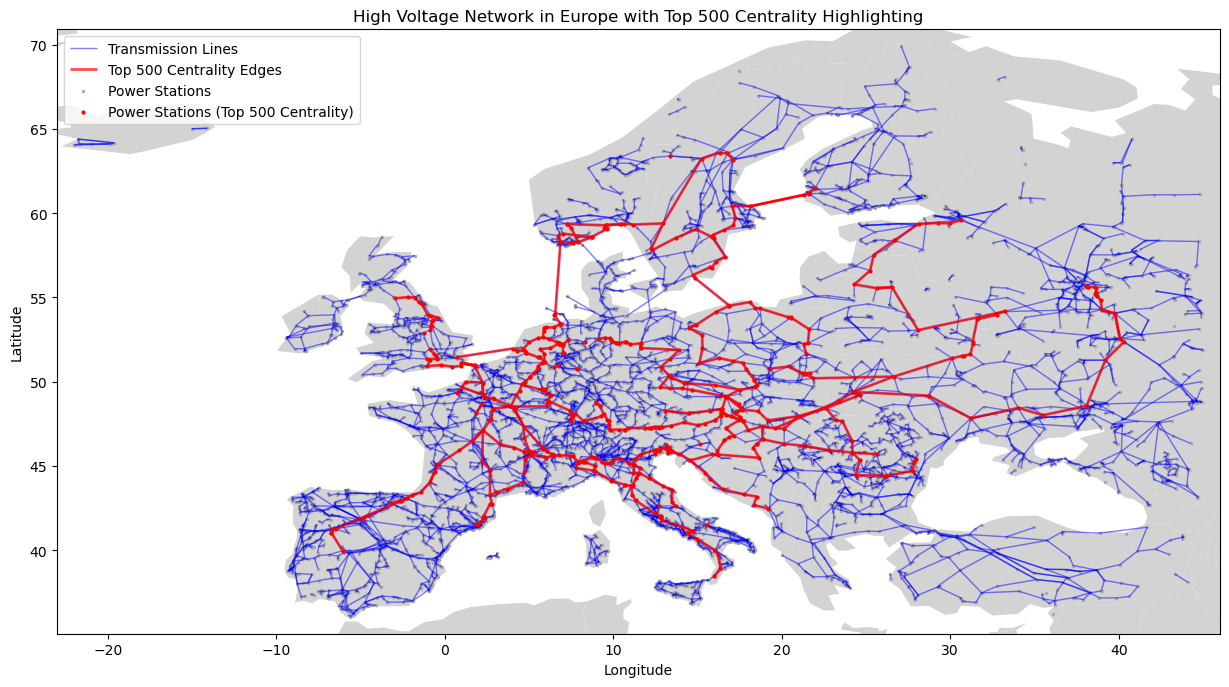

In [6]:
# Define the number of top vertices to consider
num_top_vertices = 500  # Change this value as needed

# Assuming the graph G and data frames vertices_df and links_df are already defined and loaded as per previous context
# Create GeoDataFrame for vertices with centrality information
vertices_df['centrality'] = vertices_df['v_id'].map(betweenness_centrality)
geometry = [Point(xy) for xy in zip(vertices_df.lon, vertices_df.lat)]
gdf_vertices = gpd.GeoDataFrame(vertices_df, geometry=geometry)

# Create GeoDataFrame for all edges
edge_lines = [LineString([Point(G.nodes[data['v_id_1']]['lon'], G.nodes[data['v_id_1']]['lat']),
              Point(G.nodes[data['v_id_2']]['lon'], G.nodes[data['v_id_2']]['lat'])])
        for _, data in links_df.iterrows()]
gdf_edges = gpd.GeoDataFrame(links_df, geometry=edge_lines)

# Sort vertices by centrality and select the top N vertices based on num_top_vertices
gdf_vertices_sorted = gdf_vertices.sort_values(by='centrality', ascending=False)
top_vertices = gdf_vertices_sorted.head(num_top_vertices)['v_id'].tolist()

# Filter edges where both vertices are in the top N centrality list
top_edges = links_df[links_df['v_id_1'].isin(top_vertices) & links_df['v_id_2'].isin(top_vertices)]

# Create GeoDataFrame for top edges
top_edge_lines = [LineString([Point(G.nodes[data['v_id_1']]['lon'], G.nodes[data['v_id_1']]['lat']),
                                 Point(G.nodes[data['v_id_2']]['lon'], G.nodes[data['v_id_2']]['lat'])])
                     for _, data in top_edges.iterrows()]
gdf_top_edges = gpd.GeoDataFrame(top_edges, geometry=top_edge_lines)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
# Load Europe basemap
world.plot(ax=ax, color='lightgrey')

# Plot all edges in blue
gdf_edges.plot(ax=ax, color='blue', linewidth=1, alpha=0.5, label='Transmission Lines')

# Plot top N edges in red
gdf_top_edges.plot(ax=ax, color='red', linewidth=2, alpha=0.7, label=f'Top {num_top_vertices} Centrality Edges')

# Plotting adjustments for vertices
gdf_vertices_sorted.iloc[num_top_vertices:].plot(ax=ax, marker='o', color='darkgrey', markersize=2, label='Power Stations', zorder=1)
gdf_vertices_sorted.head(num_top_vertices).plot(ax=ax, marker='o', color='red', markersize=4, label=f'Power Stations (Top {num_top_vertices} Centrality)', zorder=2)

# Set limits to zoom into the relevant part of Europe based on vertex coordinates
min_lon = vertices_df['lon'].min()
max_lon = vertices_df['lon'].max()
min_lat = vertices_df['lat'].min()
max_lat = vertices_df['lat'].max()
ax.set_xlim(min_lon - 1, max_lon + 1)  # Adding a small buffer for better visualization
ax.set_ylim(min_lat - 1, max_lat + 1)  # Adding a small buffer for better visualization

plt.legend()
plt.title(f'High Voltage Network in Europe with Top {num_top_vertices} Centrality Highlighting')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### 5. Closeness Centrality
Use Closeness Centrality to find the critically important power stations in the power grid. Visualise.

In [7]:
import networkx as nx

# Calculate closeness centrality
closeness_centrality = nx.closeness_centrality(G)

# Sort the power stations by their closeness centrality
sorted_power_stations = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)

# Print the top 10 power stations with highest closeness centrality
print("Top 10 power stations with highest closeness centrality:")
for station, centrality in sorted_power_stations[:10]:
  print(f"Power Station: {station}, Closeness Centrality: {centrality}")



Top 10 power stations with highest closeness centrality:
Power Station: 55425, Closeness Centrality: 0.02732148991283554
Power Station: 20710, Closeness Centrality: 0.027278463406704766
Power Station: 21653, Closeness Centrality: 0.027259554218249556
Power Station: 54479, Closeness Centrality: 0.02725756828838448
Power Station: 29628, Closeness Centrality: 0.027256206675135706
Power Station: 2539, Closeness Centrality: 0.027247472892722117
Power Station: 5159, Closeness Centrality: 0.02724588553359823
Power Station: 41565, Closeness Centrality: 0.027235798788372543
Power Station: 33792, Closeness Centrality: 0.027223681909779737
Power Station: 20494, Closeness Centrality: 0.02721287641438423


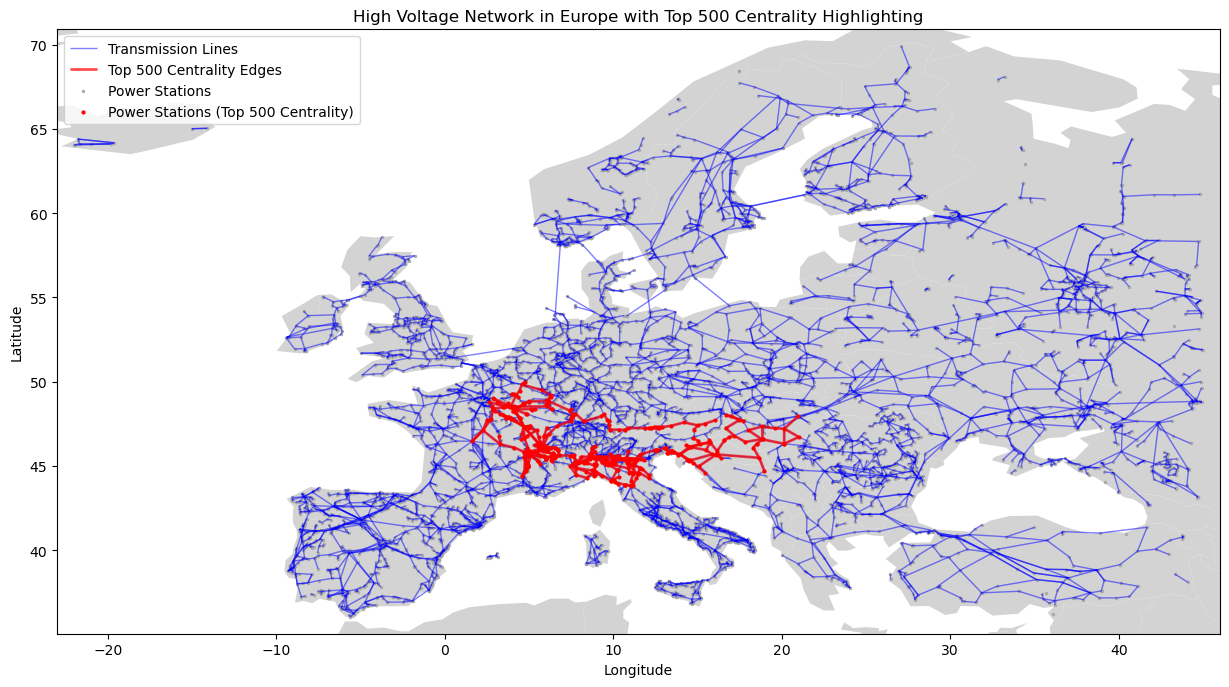

In [8]:
# Define the number of top vertices to consider
num_top_vertices = 500  # Change this value as needed

# Assuming the graph G and data frames vertices_df and links_df are already defined and loaded as per previous context
# Create GeoDataFrame for vertices with centrality information
vertices_df['centrality'] = vertices_df['v_id'].map(closeness_centrality)
geometry = [Point(xy) for xy in zip(vertices_df.lon, vertices_df.lat)]
gdf_vertices = gpd.GeoDataFrame(vertices_df, geometry=geometry)

# Create GeoDataFrame for all edges
edge_lines = [LineString([Point(G.nodes[data['v_id_1']]['lon'], G.nodes[data['v_id_1']]['lat']),
              Point(G.nodes[data['v_id_2']]['lon'], G.nodes[data['v_id_2']]['lat'])])
        for _, data in links_df.iterrows()]
gdf_edges = gpd.GeoDataFrame(links_df, geometry=edge_lines)

# Sort vertices by centrality and select the top N vertices based on num_top_vertices
gdf_vertices_sorted = gdf_vertices.sort_values(by='centrality', ascending=False)
top_vertices = gdf_vertices_sorted.head(num_top_vertices)['v_id'].tolist()

# Filter edges where both vertices are in the top N centrality list
top_edges = links_df[links_df['v_id_1'].isin(top_vertices) & links_df['v_id_2'].isin(top_vertices)]

# Create GeoDataFrame for top edges
top_edge_lines = [LineString([Point(G.nodes[data['v_id_1']]['lon'], G.nodes[data['v_id_1']]['lat']),
                                 Point(G.nodes[data['v_id_2']]['lon'], G.nodes[data['v_id_2']]['lat'])])
                     for _, data in top_edges.iterrows()]
gdf_top_edges = gpd.GeoDataFrame(top_edges, geometry=top_edge_lines)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
# Load Europe basemap
world.plot(ax=ax, color='lightgrey')

# Plot all edges in blue
gdf_edges.plot(ax=ax, color='blue', linewidth=1, alpha=0.5, label='Transmission Lines')

# Plot top N edges in red
gdf_top_edges.plot(ax=ax, color='red', linewidth=2, alpha=0.7, label=f'Top {num_top_vertices} Centrality Edges')

# Plotting adjustments for vertices
gdf_vertices_sorted.iloc[num_top_vertices:].plot(ax=ax, marker='o', color='darkgrey', markersize=2, label='Power Stations', zorder=1)
gdf_vertices_sorted.head(num_top_vertices).plot(ax=ax, marker='o', color='red', markersize=4, label=f'Power Stations (Top {num_top_vertices} Centrality)', zorder=2)

# Set limits to zoom into the relevant part of Europe based on vertex coordinates
min_lon = vertices_df['lon'].min()
max_lon = vertices_df['lon'].max()
min_lat = vertices_df['lat'].min()
max_lat = vertices_df['lat'].max()
ax.set_xlim(min_lon - 1, max_lon + 1)  # Adding a small buffer for better visualization
ax.set_ylim(min_lat - 1, max_lat + 1)  # Adding a small buffer for better visualization

plt.legend()
plt.title(f'High Voltage Network in Europe with Top {num_top_vertices} Centrality Highlighting')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### 6. Eigenvector Centrality
Use Closeness Centrality to find the critically important power stations in the power grid. Visualise.

In [9]:
import networkx as nx

# Extract the largest component from G
largest_component = max(nx.connected_components(G), key=len)
G_largest_component = G.subgraph(largest_component)

# Calculate eigenvector centrality for the largest component
eigenvector_centrality = nx.eigenvector_centrality(G_largest_component, max_iter=1000)

# Sort the power stations by their eigenvector centralityy
sorted_power_stations = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)


# Print the top 10 power stations with highest eigenvector centrality
print("Top 10 power stations with highest eigenvector centrality:")
for station, centrality in sorted_power_stations[:10]:
  print(f"Power Station: {station}, Eigenvector Centrality: {centrality}")



Top 10 power stations with highest eigenvector centrality:
Power Station: 39665, Eigenvector Centrality: 0.5706438117893131
Power Station: 45847, Eigenvector Centrality: 0.275604825647729
Power Station: 5638, Eigenvector Centrality: 0.23215710017071364
Power Station: 32899, Eigenvector Centrality: 0.2111695575733885
Power Station: 21201, Eigenvector Centrality: 0.19393237062785273
Power Station: 33318, Eigenvector Centrality: 0.18752890980550993
Power Station: 39666, Eigenvector Centrality: 0.18312144812041256
Power Station: 28368, Eigenvector Centrality: 0.17431369001323505
Power Station: 60957, Eigenvector Centrality: 0.17431369001323505
Power Station: 67356, Eigenvector Centrality: 0.17410414764362486


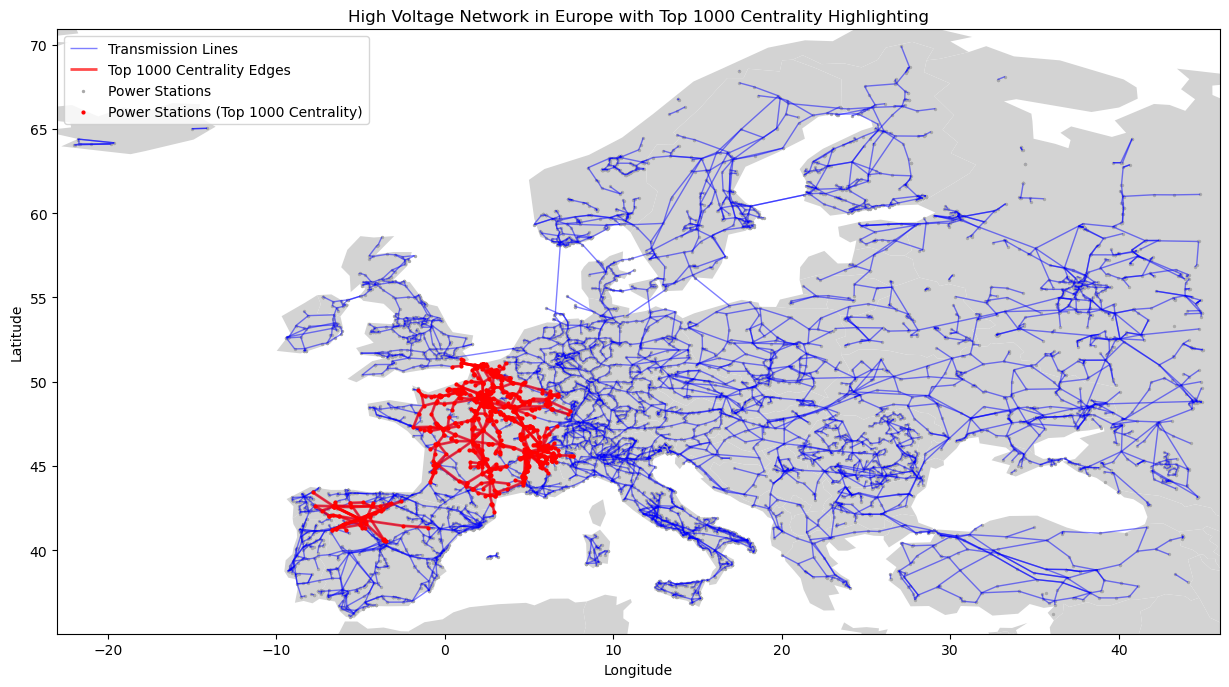

In [10]:
# Define the number of top vertices to consider
num_top_vertices = 1000  # Change this value as needed

# Assuming the graph G and data frames vertices_df and links_df are already defined and loaded as per previous context
# Create GeoDataFrame for vertices with centrality information
vertices_df['centrality'] = vertices_df['v_id'].map(eigenvector_centrality)
geometry = [Point(xy) for xy in zip(vertices_df.lon, vertices_df.lat)]
gdf_vertices = gpd.GeoDataFrame(vertices_df, geometry=geometry)

# Create GeoDataFrame for all edges
edge_lines = [LineString([Point(G.nodes[data['v_id_1']]['lon'], G.nodes[data['v_id_1']]['lat']),
              Point(G.nodes[data['v_id_2']]['lon'], G.nodes[data['v_id_2']]['lat'])])
        for _, data in links_df.iterrows()]
gdf_edges = gpd.GeoDataFrame(links_df, geometry=edge_lines)

# Sort vertices by centrality and select the top N vertices based on num_top_vertices
gdf_vertices_sorted = gdf_vertices.sort_values(by='centrality', ascending=False)
top_vertices = gdf_vertices_sorted.head(num_top_vertices)['v_id'].tolist()

# Filter edges where both vertices are in the top N centrality list
top_edges = links_df[links_df['v_id_1'].isin(top_vertices) & links_df['v_id_2'].isin(top_vertices)]

# Create GeoDataFrame for top edges
top_edge_lines = [LineString([Point(G.nodes[data['v_id_1']]['lon'], G.nodes[data['v_id_1']]['lat']),
                                 Point(G.nodes[data['v_id_2']]['lon'], G.nodes[data['v_id_2']]['lat'])])
                     for _, data in top_edges.iterrows()]
gdf_top_edges = gpd.GeoDataFrame(top_edges, geometry=top_edge_lines)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
# Load Europe basemap
world.plot(ax=ax, color='lightgrey')

# Plot all edges in blue
gdf_edges.plot(ax=ax, color='blue', linewidth=1, alpha=0.5, label='Transmission Lines')

# Plot top N edges in red
gdf_top_edges.plot(ax=ax, color='red', linewidth=2, alpha=0.7, label=f'Top {num_top_vertices} Centrality Edges')

# Plotting adjustments for vertices
gdf_vertices_sorted.iloc[num_top_vertices:].plot(ax=ax, marker='o', color='darkgrey', markersize=2, label='Power Stations', zorder=1)
gdf_vertices_sorted.head(num_top_vertices).plot(ax=ax, marker='o', color='red', markersize=4, label=f'Power Stations (Top {num_top_vertices} Centrality)', zorder=2)

# Set limits to zoom into the relevant part of Europe based on vertex coordinates
min_lon = vertices_df['lon'].min()
max_lon = vertices_df['lon'].max()
min_lat = vertices_df['lat'].min()
max_lat = vertices_df['lat'].max()
ax.set_xlim(min_lon - 1, max_lon + 1)  # Adding a small buffer for better visualization
ax.set_ylim(min_lat - 1, max_lat + 1)  # Adding a small buffer for better visualization

plt.legend()
plt.title(f'High Voltage Network in Europe with Top {num_top_vertices} Centrality Highlighting')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [11]:
print(G_largest_component)

Graph with 13478 nodes and 16922 edges
